In [146]:
# in google colab uncomment this

import os

os.system('apt-get install -y xvfb')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')

os.system('python -m pip install -U pygame --user')

print('setup complete')

# XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    %env DISPLAY = : 1

setup complete


In [147]:
import sys
!rm -r yandex-rl-tasks
!git clone https://github.com/denklewer/yandex-rl-tasks.git
sys.path.append(os.path.join("", 'yandex-rl-tasks')) # To find local version of the library


Cloning into 'yandex-rl-tasks'...
remote: Enumerating objects: 197, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 197 (delta 106), reused 118 (delta 50), pack-reused 0
Receiving objects: 100% (197/197), 9.86 MiB | 18.17 MiB/s, done.
Resolving deltas: 100% (106/106), done.


# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using 
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here. 



In [148]:
import numpy as np
from util.atari_wrappers_a2c import nature_dqn_env



env = nature_dqn_env("SpaceInvadersNoFrameskip-v4",summaries=False, nenvs=8)
obs = env.reset()
print("obs.shape" , obs.shape)
assert obs.dtype == np.uint8
n_actions = env.action_space.n

obs.shape (8, 84, 84, 4)


(8, 84, 84, 4)


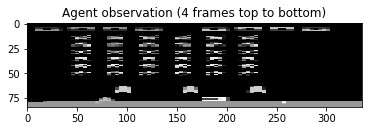

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.title("Agent observation (4 frames top to bottom)")
print(obs.shape)

plt.imshow( obs[0].reshape(84, -1), cmap='gray')
plt.show()

Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros. 

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# those who have a GPU but feel unfair to use it can uncomment:
# device = torch.device('cpu')

In [0]:
def conv2d_size_out(size, kernel_size=3, stride=2):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride + 1


class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)
      
      
def to_one_hot(y_tensor, ndims):
    """ helper: take an integer vector and convert it to 1-hot matrix. """
    y_tensor = torch.LongTensor(y_tensor).view(-1,1)
    y_one_hot = torch.zeros(
        y_tensor.size()[0], ndims).scatter_(1, y_tensor, 1)
    return y_one_hot.cuda()

In [0]:
import math
def weights_init(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        nn.init.orthogonal(m.weight.data, math.sqrt(2.0))
        if m.bias is not None:
            m.bias.data.fill_(0)

class Agent(nn.Module):
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        super(Agent, self).__init__()

        # Prepare neural network architecture
        # Your code here: prepare any necessary layers, variables, etc.
        self.n_actions = n_actions
        self.state_shape = state_shape
        print(state_shape)
        n_env, h, w, c = state_shape

        self.common = nn.Sequential(
            nn.Conv2d(c, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=2),
            nn.ReLU(),
            Flatten()
        )

        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        # we want to flatten given images to verctor for dense layers.
        print("linear input size = ", linear_input_size)
        self.fc = nn.Sequential(
            nn.Linear(linear_input_size, 128),
            nn.ReLU()
        )

        self.Vs = nn.Linear(128, 1)
        self.logits = nn.Linear(128, n_actions)

        self.common.apply(weights_init)
        self.fc.apply(weights_init)
        self.Vs.apply(weights_init)
        self.logits.apply(weights_init)

    def forward(self, state_t):
        """
        Takes agent's previous step and observation, 
        returns next state and whatever it needs to learn (tf tensors)
        """
        # Apply neural network
        ### Your code here: apply agent's neural network to get policy logits and state values.
        state_t = torch.tensor(state_t, device=device, dtype=torch.float);
        state_t = state_t.permute(0,3,1,2)
        state_t = self.common(state_t)
        state_t = self.fc(state_t)
        logits = self.logits(state_t)
        state_value = self.Vs(state_t)[:, 0]
        return logits, state_value


You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework. 

In [0]:
class Policy:
    def __init__(self, model):
        self.model = model
    def sample_actions(self, logits):
        """pick actions given numeric agent outputs (np arrays)"""
        policy =  F.softmax(logits, dim=1).detach().cpu().numpy()
        actions = np.array([np.random.choice(len(p), p=p) for p in policy])
        return actions

    def logprobs(self, logits, actions):
        log_probs = F.log_softmax(logits, dim=1)
        action_log_probs =  torch.sum(log_probs * to_one_hot(actions, env.action_space.n), dim=-1)
        return action_log_probs
    
    def act(self, inputs):
        agent_outputs = model.forward(inputs)
        logits, state_values = agent_outputs
        actions = self.sample_actions(logits)
        action_log_probs = self.logprobs(logits, actions) 
        return {
            'actions': actions,
            'logits': logits,
            'log_probs': action_log_probs,
            'values': state_values
        }
    # Should return a dict containing keys ['actions', 'logits', 'log_probs', 'values'].

Next will pass the environment and policy to a runner that collects partial trajectories from the environment. 
The class that does is is already implemented for you.

In [0]:
from util.runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory. 

To train the part of the model that predicts state values you will need to compute the value targets. 
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 
The formula for the value targets is simple:

$$
\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use 
`trajectory['resets']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [0]:
import collections
class ComputeValueTargets:
  def __init__(self, gamma=0.99):
    self.gamma = gamma
      
  def __call__(self, trajectory):
    # This method should modify trajectory inplace by adding 
    # an item with key 'value_targets' to it.
    n_env = len(trajectory['resets'][0]);
    T = len(trajectory['resets'])
    result_arr = collections.defaultdict(list);
    result_list = []
 
    for i in range(n_env):
      rewards = [trajectory['rewards'][k][i] for k in range(T)]
      resets = [trajectory['resets'][k][i] for k in range(T)]
      value_targets = [0 if trajectory['resets'][-1][i] else trajectory['values'][-1][i]]
      for reward, done in list(zip(rewards, resets))[-2::-1]:
        if not done:
          value_targets.append(reward + self.gamma * value_targets[-1])
        else:
          value_targets.append(0)
          
      result_list.append(value_targets[::-1])
    #transpose result_list
    result_list = list(map(list, zip(*result_list)))
    trajectory['value_targets'] = result_list
    return trajectory
    

In [0]:
import collections
def printTrajectory(p_trajectory):
    for key,values in p_trajectory.items():
      print(key)
      if key != "observations" and key != "state":
        print(values)
#       for i, timed_value in enumerate(values):
#         print("time- ", i, ":", timed_value)
    
    

def testComputeValueTargets():
  test_trajectory = collections.defaultdict(list);
  n_env = 8
  T = 10
  values = [[1 for i in range(n_env)] for t in range(T)]
  rewards = [[1 for i in range(n_env)] for t in range(T)]
  resets = [[False for i in range(n_env)] for t in range(T)]
  resets[4][0] = True
  resets[9][1] = True
  resets[3][2] = True
  resets[9][2] = True
  resets[4][3] = True
  resets[6][3] = True
  resets[8][3] = True

  test_trajectory['rewards'] = rewards
  test_trajectory['values'] = values
  test_trajectory['resets'] = resets
  
  printTrajectory(test_trajectory)
 
  
  return ComputeValueTargets().__call__(test_trajectory)

In [157]:
print("result")

printTrajectory(testComputeValueTargets())

result
rewards
[[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]
values
[[1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1]]
resets
[[False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False], [False, False, True, False, False, False, False, False], [True, False, False, True, False, False, False, False], [False, False, False, False, False, False, False, False], [False, False, False, True, False, False, False, False], [False, False, False, False, False, False, Fal

After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`, i.e. you essentially need
to flatten the first two dimensions. 

In [0]:
class MergeTimeBatch:
  """ Merges first two axes typically representing time and env batch. """
  def __call__(self, trajectory):
    # Modify trajectory inplace.
#     for key, stack in trajectory.items():
#         trajectory[key] = stack.reshape(-1, *stack.shape[2:])


    return trajectory
        

In [159]:
model = Agent("Agent", obs.shape, n_actions).to(device)
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=5,
                   transforms=[ComputeValueTargets(),
                               MergeTimeBatch()])
eval_runner =EnvRunner(env, policy, nsteps=30)

(8, 84, 84, 4)
linear input size =  2592


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  after removing the cwd from sys.path.


In [0]:
def evaluate(agent, env, n_games=1):
    """Plays an a game from start till done, returns per-game rewards """

    game_rewards = []
    for _ in range(n_games):
        state = env.reset()
        
        total_reward = 0
        
        trajectory = eval_runner.get_next()
#         while True:
#             action = agent.sample_actions(agent.step([state]))[0]
#             state, reward, done, info = env.step(action)
#             total_reward += reward
#             if done: break
                
#         game_rewards.append(total_reward)
        game_rewards = trajectory['rewards']
        
    return np.sum(game_rewards, axis=0)

In [0]:
summa = evaluate(model, env)

Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [0]:
class A2C:
  def __init__(self,
               policy,
               optimizer,
               value_loss_coef=0.25,
               entropy_coef=0.01,
               max_grad_norm=0.5):
    self.policy = policy
    self.optimizer = optimizer
    self.value_loss_coef = value_loss_coef
    self.entropy_coef = entropy_coef
    self.max_grad_norm = max_grad_norm
    
  def policy_loss(self, trajectory):
    # You will need to compute advantages here.
    advantages = trajectory['value_targets'] - trajectory['values']
    return - torch.mean(trajectory['log_probs'] * advantages.detach())
    
    
  def value_loss(self, trajectory):

    advantages = trajectory['value_targets'] - trajectory['values']
    value_loss = advantages.pow(2).mean()
    return value_loss
    
  def loss(self, trajectory):
    value_loss = self.value_loss(trajectory)
    action_loss = self.policy_loss(trajectory)
    
    probs = F.softmax(trajectory['logits'], dim=-1) 
    logprobs = F.log_softmax(trajectory['logits'], dim=-1)

    #TODO: entropy clarification
    dist_entropy = -(probs * logprobs).sum(-1).sum(-1).mean()
    return value_loss, action_loss, dist_entropy
      
  def step(self, trajectory):
    trajectory['values'] = torch.stack(trajectory['values'])
    trajectory['log_probs'] = torch.stack(trajectory['log_probs'])
    trajectory['logits'] = torch.stack(trajectory['logits'])
    trajectory['observations'] = torch.tensor(trajectory['observations'], device=device, dtype=torch.float)    
    trajectory['rewards'] = torch.tensor(trajectory['rewards'], device=device, dtype=torch.float)
    trajectory['value_targets'] = torch.tensor(trajectory['value_targets'],  device=device, dtype=torch.float)
    
    value_loss, action_loss, dist_entropy = self.loss(trajectory)
    (value_loss * self.value_loss_coef + action_loss - dist_entropy * self.entropy_coef).backward()
    grad_norm = nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)

    self.optimizer.step()
    self.optimizer.zero_grad() 
    return value_loss,action_loss, dist_entropy, grad_norm

Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last 
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with all environments. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.


  0%|          | 0/100000 [00:00<?, ?it/s]

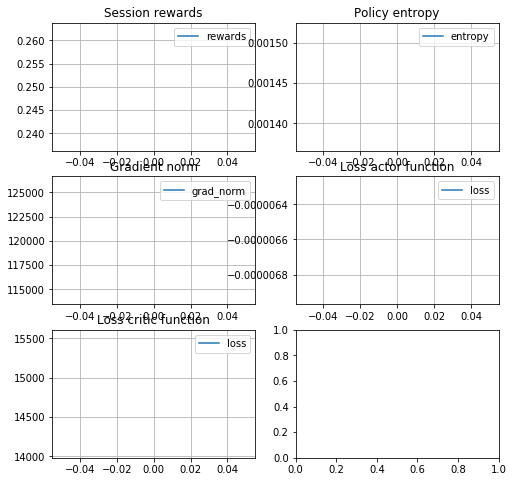


  0%|          | 18/100000 [00:09<12:29:35,  2.22it/s]

KeyboardInterrupt: ignored

In [169]:
from IPython.display import clear_output
from tqdm import trange
def adjust_lr(optimizer, epoch):
    lr = init_lr * (0.1 ** (epoch // 20))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-2, alpha=0.99, eps=1e-5)
a2c = A2C(policy,
          optimizer,
          value_loss_coef=0.25,
          entropy_coef=0.01,
          max_grad_norm=0.5)

loss_freq = 500
rewards_freq = 2500
entropy_freq = 500
rewards_history = []
entropy_history = []
loss_act_history = []
loss_cri_history = []
grad_norm_history = []

for step in trange(100000): 
    trajectory = runner.get_next()

    value_loss,action_loss, dist_entropy, grad_norm =  a2c.step(trajectory)

    if step % loss_freq == 0:
        loss_act_history.append(action_loss.data.cpu().item())
        loss_cri_history.append(value_loss.data.cpu().item())
        grad_norm_history.append(grad_norm)

    if step % entropy_freq == 0: 
      entropy_history.append(np.mean(dist_entropy.data.cpu().numpy()))
      if step % rewards_freq == 0:
        rewards = evaluate(model, env)
        rewards_history.append(rewards.mean())
        if rewards_history[-1] >= 50:
          print("Your agent has earned the yellow belt" % color)

          clear_output(True)
        
        fig,((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=[8,8])
        ax1.plot(rewards_history ,label='rewards')
        ax1.set_title("Session rewards")
        ax1.legend()
        ax1.grid()
        
        ax2.plot(entropy_history ,label='entropy')
        ax2.set_title("Policy entropy")       
        ax2.legend()
        ax2.grid()
        
        ax3.plot(grad_norm_history ,label='grad_norm')
        ax3.set_title("Gradient norm") 
        ax3.legend()
        ax3.grid()
        
        ax4.plot(loss_act_history ,label='loss')
        ax4.set_title("Loss actor function")   
        ax4.legend()
        ax4.grid()
        
        ax5.plot(loss_cri_history ,label='loss')
        ax5.set_title("Loss critic function")   
        ax5.legend()
        ax5.grid()

        
        plt.show()
        